In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.model_selection import train_test_split

In [28]:
file_time_a = '../time_a_df_test.csv'
file_time_b_decay = '../time_b_df_test.csv'
#file_time_b_normal = '../time_b_df_test.csv'
#file_time_b_growth = '../time_b_df_test.csv'


time_a_df = pd.read_csv(file_time_a)

time_b_decay_df = pd.read_csv(file_time_b_decay)
#time_b_growth = pd.read_csv(file_time_b_growth)
#time_b_normal = pd.read_csv(file_time_b_normal)

if "Unnamed: 0" in time_a_df.columns:
    time_a_df.drop(columns=["Unnamed: 0"], inplace=True)
if "Unnamed: 0" in time_b_decay_df.columns:
    time_b_decay_df.drop(columns=["Unnamed: 0"], inplace=True)
   #time_b_growth_df.drop(columns=["Unnamed: 0"], inplace=True)
    #time_b_normal_df.drop(columns=["Unnamed: 0"], inplace=True)

time_a_df["Date"] = pd.to_datetime(time_a_df["Date"])
time_b_decay_df["Date"] = pd.to_datetime(time_b_decay_df["Date"])
#time_b_growth_df["Date"] = pd.to_datetime(time_b_growth_df["Date"])
#time_b_normal_df["Date"] = pd.to_datetime(time_b_normal_df["Date"])

In [29]:
features = ["CTR", "Engagement"]

In [30]:
# Split Time A into 80% training and 20% testing
time_a_train, time_a_test = train_test_split(time_a_df, test_size=0.2, random_state=42, shuffle=True)

drift_threshold = 0.01

🚨 First Drift detected for CTR on 2024-07-01 00:00:00 with deviation of 0.015107


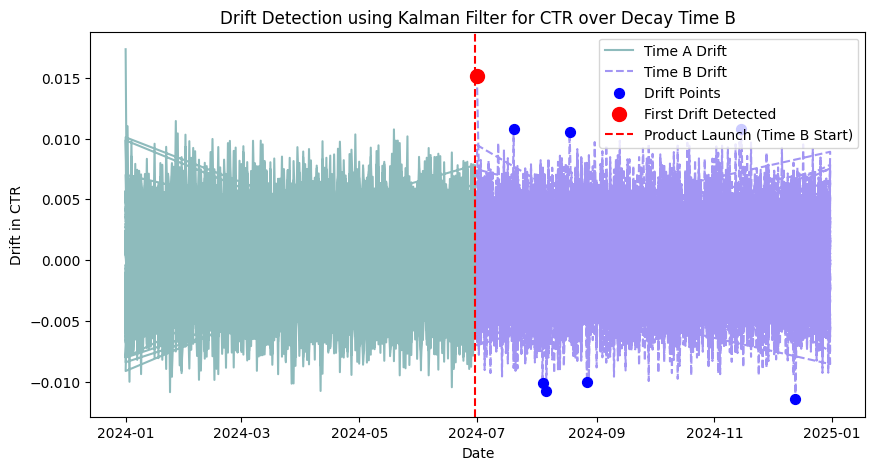

🚨 First Drift detected for Engagement on 2024-07-01 00:00:00 with deviation of 13.746354


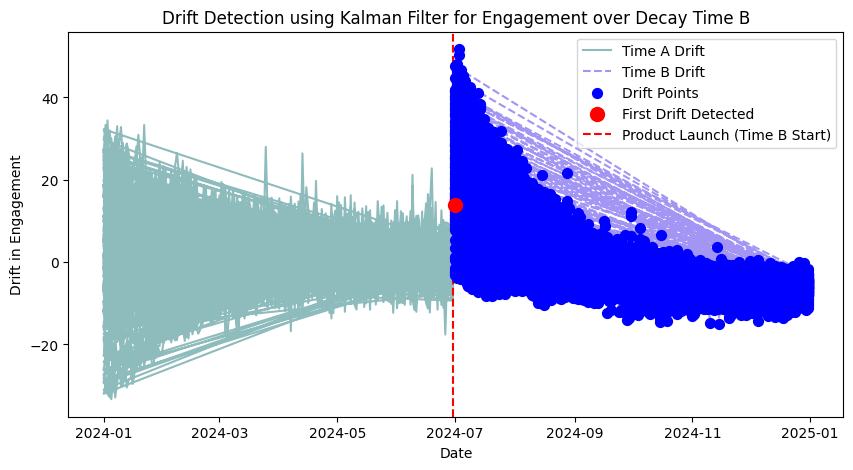

In [ ]:
# DECAY

for feature in features:
    # Initialize Kalman Filter
    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), 
                      initial_state_covariance=1,
                      transition_matrices=[1], 
                      observation_matrices=[1],
                      observation_covariance=1,
                      transition_covariance=0.01) 

    # Train Kalman Filter on 80% of Time A
    kf = kf.em(time_a_train[feature].values, n_iter=10)

    # Test on 20% of Time A
    filtered_state_means_test, _ = kf.filter(time_a_test[feature].values)
    drift_test = time_a_test[feature].values - filtered_state_means_test.flatten()

    # Apply Kalman Filter to all of Time A and Time B
    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)
    filtered_state_means_b, _ = kf.filter(time_b_decay_df[feature].values)

    # Calculate drift (Actual - Estimated)
    drift_time_a = time_a_df[feature].values - filtered_state_means_a.flatten()
    drift_time_b_decay = time_b_decay_df[feature].values - filtered_state_means_b.flatten()


    # Detect all points where drift exceeds threshold
    drift_indices = np.where(np.abs(drift_time_b_decay) > drift_threshold)[0]
    
    # Store detected drift points
    drift_dates = time_b_decay_df["Date"].iloc[drift_indices]
    drift_values = drift_time_b_decay[drift_indices]

    # Identify first detected drift event
    first_drift_date = None
    first_drift_value = None

    if len(drift_indices) > 0:
        first_drift_date = drift_dates.iloc[0]
        first_drift_value = drift_values[0]
        print(f"First Drift detected for {feature} on {first_drift_date} with deviation of {first_drift_value:.6f}")

    # Plot drift over time
    plt.figure(figsize=(10, 5))
    plt.plot(time_a_df["Date"], drift_time_a, label="Time A Drift", alpha=0.7, color="cadetblue")
    plt.plot(time_b_decay_df["Date"], drift_time_b_decay, label="Time B Drift", alpha=0.7, color="mediumslateblue", linestyle="dashed")
    
    # Mark all drift points
    plt.scatter(drift_dates, drift_values, color="blue", label="Drift Points", zorder=3, s=50)

    # Highlight first drift detection separately
    if first_drift_date:
        plt.scatter(first_drift_date, first_drift_value, color="red", label="First Drift Detected", zorder=3, s=100)

    # Mark product launch
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")
    
    plt.xlabel("Date")
    plt.ylabel(f"Drift in {feature}")
    plt.title(f"Drift Detection using Kalman Filter for {feature} over Decay Time B")
    plt.legend()
    plt.show()

In [32]:
"""
# GROWTH

for feature in features:
    # Initialize Kalman Filter
    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), 
                      initial_state_covariance=1,
                      transition_matrices=[1], 
                      observation_matrices=[1],
                      observation_covariance=1,
                      transition_covariance=0.01) 

    # Train Kalman Filter on 80% of Time A
    kf = kf.em(time_a_train[feature].values, n_iter=10)

    # Test on 20% of Time A
    filtered_state_means_test, _ = kf.filter(time_a_test[feature].values)
    drift_test = time_a_test[feature].values - filtered_state_means_test.flatten()

    # Apply Kalman Filter to all of Time A and Time B
    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)
    filtered_state_means_b, _ = kf.filter(time_b_growth_df[feature].values)

    # Calculate drift (Actual - Estimated)
    drift_time_a = time_a_df[feature].values - filtered_state_means_a.flatten()
    drift_time_b_growth = time_b_growth_df[feature].values - filtered_state_means_b.flatten()

    # Plot drift over time
    plt.figure(figsize=(10, 5))
    plt.plot(time_a_df["Date"], drift_time_a, label="Time A Drift", alpha=0.7, color="cadetblue")
    plt.plot(time_b_growth_df["Date"], drift_time_b_growth, label="Time B Drift", color="orchid", alpha=0.7, linestyle="dashed")
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")
    plt.xlabel("Date")
    plt.ylabel(f"Drift in {feature}")
    plt.title(f"Drift Detection using Kalman Filter for {feature} over Growth Time B")
    plt.legend()
    plt.show()

    """

'\n# GROWTH\n\nfor feature in features:\n    # Initialize Kalman Filter\n    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), \n                      initial_state_covariance=1,\n                      transition_matrices=[1], \n                      observation_matrices=[1],\n                      observation_covariance=1,\n                      transition_covariance=0.01) \n\n    # Train Kalman Filter on 80% of Time A\n    kf = kf.em(time_a_train[feature].values, n_iter=10)\n\n    # Test on 20% of Time A\n    filtered_state_means_test, _ = kf.filter(time_a_test[feature].values)\n    drift_test = time_a_test[feature].values - filtered_state_means_test.flatten()\n\n    # Apply Kalman Filter to all of Time A and Time B\n    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)\n    filtered_state_means_b, _ = kf.filter(time_b_growth_df[feature].values)\n\n    # Calculate drift (Actual - Estimated)\n    drift_time_a = time_a_df[feature].values - filtered_sta

In [33]:
"""
# NORMAL

for feature in features:
    # Initialize Kalman Filter
    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), 
                      initial_state_covariance=1,
                      transition_matrices=[1], 
                      observation_matrices=[1],
                      observation_covariance=1,
                      transition_covariance=0.01) 

    # Train Kalman Filter on 80% of Time A
    kf = kf.em(time_a_train[feature].values, n_iter=10)

    # Test on 20% of Time A
    filtered_state_means_test, _ = kf.filter(time_a_test[feature].values)
    drift_test = time_a_test[feature].values - filtered_state_means_test.flatten()

    # Apply Kalman Filter to all of Time A and Time B
    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)
    filtered_state_means_b, _ = kf.filter(time_b_normal_df[feature].values)

    # Calculate drift (Actual - Estimated)
    drift_time_a = time_a_df[feature].values - filtered_state_means_a.flatten()
    drift_time_b_normal = time_b_normal_df[feature].values - filtered_state_means_b.flatten()

    # Plot drift over time
    plt.figure(figsize=(10, 5))
    plt.plot(time_a_df["Date"], drift_time_a, label="Time A Drift", alpha=0.7, color="cadetblue")
    plt.plot(time_b_normal_df["Date"], drift_time_b_normal, label="Time B Drift", color="orchid", alpha=0.7, linestyle="dashed")
    plt.axvline(x=time_a_df["Date"].iloc[-1], color="red", linestyle="--", label="Product Launch (Time B Start)")
    plt.xlabel("Date")
    plt.ylabel(f"Drift in {feature}")
    plt.title(f"Drift Detection using Kalman Filter for {feature} over Normal Time B")
    plt.legend()
    plt.show()"
"""

'\n# NORMAL\n\nfor feature in features:\n    # Initialize Kalman Filter\n    kf = KalmanFilter(initial_state_mean=np.mean(time_a_train[feature]), \n                      initial_state_covariance=1,\n                      transition_matrices=[1], \n                      observation_matrices=[1],\n                      observation_covariance=1,\n                      transition_covariance=0.01) \n\n    # Train Kalman Filter on 80% of Time A\n    kf = kf.em(time_a_train[feature].values, n_iter=10)\n\n    # Test on 20% of Time A\n    filtered_state_means_test, _ = kf.filter(time_a_test[feature].values)\n    drift_test = time_a_test[feature].values - filtered_state_means_test.flatten()\n\n    # Apply Kalman Filter to all of Time A and Time B\n    filtered_state_means_a, _ = kf.filter(time_a_df[feature].values)\n    filtered_state_means_b, _ = kf.filter(time_b_normal_df[feature].values)\n\n    # Calculate drift (Actual - Estimated)\n    drift_time_a = time_a_df[feature].values - filtered_sta